In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import feature.util as feature_util
import h5py
import numpy as np
import tqdm
from collections import OrderedDict
import modisco

### Define constants/paths and import SHAP scores

In [ ]:
shap_score_hdf5_path = "/users/amtseng/tfmodisco/motifs/SPI1/importance_scores.h5"

reference_fasta = "/users/amtseng/genomes/hg38.fasta"
padded_size = 400  # Length of sequence used in explanation

In [ ]:
score_reader = h5py.File(shap_score_hdf5_path, "r")

### Create sequence one-hot encoder

In [ ]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=padded_size)

### Read in hypothetical importances and compute actual importances
Prepare them for passing to TF-MoDISco

In [ ]:
# Get shapes; we'll need to cut off inputs outside the central `padded_size`
num_seqs, input_length, _ = score_reader["prof_scores"].shape
center_start = (input_length // 2) - (padded_size // 2)
center_end = center_start + padded_size

In [ ]:
# Read in hypothetical scores, cutting off everything outside central `padded_size`
hyp_scores = np.empty((num_seqs, padded_size, 4), dtype=float)
batch_size = 1000
num_batches = int(np.ceil(num_seqs / batch_size))
for i in tqdm.tqdm_notebook(range(num_batches)):
    s, e = i * batch_size, (i + 1) * batch_size
    hyp_scores[s : e, :, :] = score_reader["prof_scores"][s : e, center_start : center_end, :]

In [ ]:
# Read in coordinates and compute 1-hot encoding
coords = np.empty((num_seqs, 3), dtype=object)
coords[:, 0] = score_reader["coords_chrom"][:].astype(str)
coords[:, 1] = score_reader["coords_start"][:]
coords[:, 2] = score_reader["coords_end"][:]

input_seqs = np.empty((num_seqs, padded_size, 4), dtype=float)

batch_size = 1000
num_batches = int(np.ceil(num_seqs / batch_size))
for i in tqdm.tqdm_notebook(range(num_batches)):
    s, e = i * batch_size, (i + 1) * batch_size
    input_seqs[s : e, :, :] = coords_to_seq(coords[s : e])

In [ ]:
# Compute actual scores
act_scores = hyp_scores * input_seqs

In [ ]:
# Prepare inputs
inds = np.random.permutation(num_seqs)[:100]

In [ ]:
task_to_hyp_scores, task_to_act_scores = OrderedDict(), OrderedDict()
task_to_hyp_scores["task0"] = list(hyp_scores[inds])
task_to_act_scores["task0"] = list(act_scores[inds])
one_hot = list(input_seqs[inds])

### Run TF-MoDISco

In [12]:
tfm_workflow = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
#     sliding_window_size=15,
#     flank_size=5,
#     target_seqlet_fdr=0.15,
    seqlets_to_patterns_factory=modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
#         trim_to_window_size=15,
#         initial_flank_to_add=5,
#         kmer_len=5,
#         num_gaps=1,
#         num_mismatches=0,
#         final_min_cluster_size=60
    )
)

In [ ]:
tfm_results = tfm_workflow(
    task_names=["task0"],
    contrib_scores=task_to_act_scores,
    hypothetical_contribs=task_to_hyp_scores,
    one_hot=one_hot
)

### Use smaller set of score (temporary)

In [2]:
import numpy as np
import modisco

TF-MoDISco is using the TensorFlow backend.
/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dt

In [3]:
act_scores = np.load("/users/amtseng/tfmodisco/motifs/SPI1/mini_100_test/act_scores.npy")
hyp_scores = np.load("/users/amtseng/tfmodisco/motifs/SPI1/mini_100_test/hyp_scores.npy")
one_hot = np.load("/users/amtseng/tfmodisco/motifs/SPI1/mini_100_test/one_hot.npy")

MEMORY 0.296378368
On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.0004988547114265353
Computing threshold
Thresholds from null dist were -0.23631814114632732  and  0.260622035205597
Final raw thresholds are -0.23631814114632732  and  0.260622035205597
Final transformed thresholds are -0.8468134715025907  and  0.8587305699481865


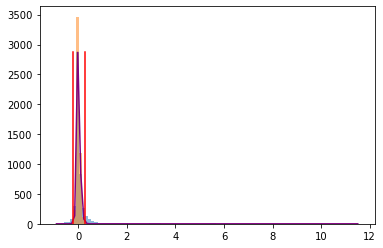

Got 459 coords
After resolving overlaps, got 459 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8468133715025907
MEMORY 0.326189056
459 identified in total
2 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  [352, 107]
Idx to activities:  {0: '1', 1: '-1'}
MEMORY 0.326295552
On metacluster 1
Metacluster size 107
Relevant tasks:  ('task0',)
Relevant signs:  (-1,)

TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 107
(Round 1) Computing coarse affmat
MEMORY 0.328359936
Beginning embedding computation
Computing embeddings
MAKING A SESSION


Finished embedding computation in 4.45 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.16 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.17 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 2.148990976
Computed nearest neighbors in 0

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    4.2s


Louvain completed 200 runs in 5.508883237838745 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    5.4s finished


Wrote graph to binary file in 0.010200977325439453 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.723574
After 26 runs, maximum modularity is Q = 0.7262
Louvain completed 76 runs in 11.33963394165039 seconds
Preproc + Louvain took 17.048134326934814 s
Got 8 clusters after round 1
Counts:
{1: 17, 2: 16, 7: 3, 5: 8, 6: 4, 4: 14, 0: 19, 3: 14}
MEMORY 2.148364288
(Round 1) Aggregating seqlets in each cluster
MEMORY 2.148364288
Aggregating for cluster 0 with 19 seqlets
MEMORY 2.148364288
Trimmed 0 out of 19
Dropping cluster 0 with 19 seqlets due to sign disagreement
Aggregating for cluster 1 with 17 seqlets
MEMORY 2.14837248
Trimmed 0 out of 17
Dropping cluster 1 with 17 seqlets due to sign disagreement
Aggregating for cluster 2 with 16 seqlets
MEMORY 2.14837248
Trimmed 0 out of 16
Dropping cluster 2 with 16 seqlets due to sign disagreement
Aggregating for cluster 3 with 14 seqlets
MEMORY 2.14837248
Trimmed 0 out of 14
Aggregating for cluster 4 wit

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 2.3969502449035645 seconds


[Parallel(n_jobs=4)]: Done 186 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.5s finished


Wrote graph to binary file in 0.003549337387084961 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.54358
Louvain completed 51 runs in 3.632739543914795 seconds
Preproc + Louvain took 6.164222955703735 s
Got 4 clusters after round 2
Counts:
{2: 7, 3: 5, 1: 11, 0: 16}
MEMORY 2.149777408
(Round 2) Aggregating seqlets in each cluster
MEMORY 2.149777408
Aggregating for cluster 0 with 16 seqlets
MEMORY 2.149777408
Trimmed 5 out of 16
Dropping cluster 0 with 11 seqlets due to sign disagreement
Aggregating for cluster 1 with 11 seqlets
MEMORY 2.149777408
Trimmed 1 out of 11
Aggregating for cluster 2 with 7 seqlets
MEMORY 2.149777408
Trimmed 0 out of 7
Aggregating for cluster 3 with 5 seqlets
MEMORY 2.149777408
Trimmed 0 out of 5
Got 3 clusters
Splitting into subclusters...
MEMORY 2.149777408
Merging on 3 clusters
MEMORY 2.149777408
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to pattern distances
Got 3 patterns after m

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.2s


Louvain completed 200 runs in 2.012941598892212 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.9s finished


Wrote graph to binary file in 0.06033897399902344 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.519949
Louvain completed 51 runs in 5.645232200622559 seconds
Preproc + Louvain took 7.8748133182525635 s
Got 7 clusters after round 1
Counts:
{2: 52, 1: 62, 3: 27, 4: 20, 5: 12, 0: 103, 6: 10}
MEMORY 2.189078528
(Round 1) Aggregating seqlets in each cluster
MEMORY 2.189078528
Aggregating for cluster 0 with 103 seqlets
MEMORY 2.189078528
Trimmed 22 out of 103
Aggregating for cluster 1 with 62 seqlets
MEMORY 2.189078528
Trimmed 3 out of 62
Skipped 2 seqlets
Aggregating for cluster 2 with 52 seqlets
MEMORY 2.189078528
Trimmed 6 out of 52
Aggregating for cluster 3 with 27 seqlets
MEMORY 2.189078528
Trimmed 0 out of 27
Aggregating for cluster 4 with 20 seqlets
MEMORY 2.189078528
Trimmed 4 out of 20
Aggregating for cluster 5 with 12 seqlets
MEMORY 2.189078528
Trimmed 0 out of 12
Aggregating for cluster 6 with 10 seqlets
MEMORY 2.189078528
Trimmed 0 out 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.2s


Louvain completed 200 runs in 1.8999526500701904 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.8s finished


Wrote graph to binary file in 0.030300378799438477 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.659586
After 2 runs, maximum modularity is Q = 0.679295
Louvain completed 52 runs in 5.059961557388306 seconds
Preproc + Louvain took 7.1474645137786865 s
Got 9 clusters after round 2
Counts:
{6: 10, 7: 8, 2: 34, 0: 62, 1: 35, 3: 33, 5: 18, 4: 28, 8: 7}
MEMORY 2.193248256
(Round 2) Aggregating seqlets in each cluster
MEMORY 2.193248256
Aggregating for cluster 0 with 62 seqlets
MEMORY 2.193248256
Trimmed 2 out of 62
Aggregating for cluster 1 with 35 seqlets
MEMORY 2.193248256
Trimmed 8 out of 35
Aggregating for cluster 2 with 34 seqlets
MEMORY 2.193248256
Trimmed 5 out of 34
Aggregating for cluster 3 with 33 seqlets
MEMORY 2.193248256
Trimmed 4 out of 33
Aggregating for cluster 4 with 28 seqlets
MEMORY 2.193248256
Trimmed 2 out of 28
Aggregating for cluster 5 with 18 seqlets
MEMORY 2.193248256
Trimmed 0 out of 18
Aggregating for cluster 6 with 10 s

In [4]:
null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                 task_names=["task0"],
                 contrib_scores={"task0": act_scores},
                 hypothetical_contribs={"task0": hyp_scores},
                 one_hot=one_hot,
                 null_per_pos_scores = null_per_pos_scores)

metacluster_idx 1
metacluster_idx 0
Pattern number 0


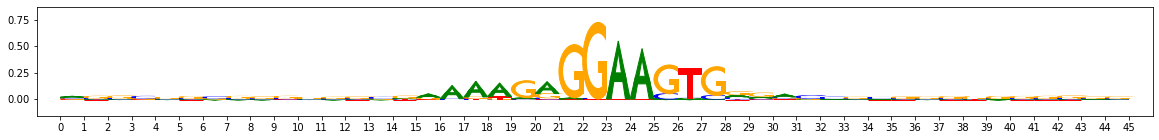

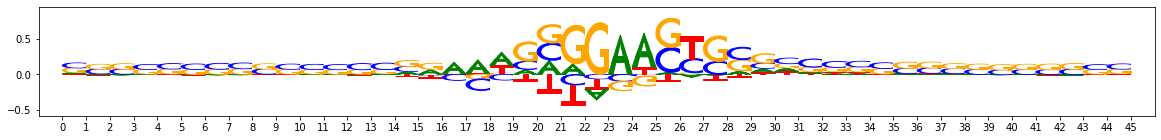

In [6]:
from modisco.visualization import viz_sequence

for metacluster_idx in tfmodisco_results.metacluster_idx_to_submetacluster_results.keys():
    print("metacluster_idx",metacluster_idx)
    submetacluster_results = tfmodisco_results.metacluster_idx_to_submetacluster_results[metacluster_idx]
    patterns = submetacluster_results.seqlets_to_patterns_result.patterns
    for idx,pattern in enumerate(patterns):
        print("Pattern number",idx)
        viz_sequence.plot_weights(pattern["task0_contrib_scores"].fwd)
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].fwd)